# Textová analytika

## Doporučení cestovateli vhodného hotelu s využitím NLP

V rámci seminární práce na textovou analytiku jsme se rozhodli pro byznys zadání doporučení vhodného hotelu cestovateli za použití NLP. 

**Kladené otázky:**

- Podle jakých parametrů nejlépe doporučit cestovateli hotel?
- Jaký je celkový sentiment recenzí?
- Dá se vypozorovat styl recenzí podle národnosti (dlouhá souvětí, více pozitivních/negativních slov v recenzi)? 
- Píší některé národnosti spíše pozitivní nebo spíše negativní recenze?
- Jaké jsou nejzajímavější hotely podle hodnocení recenzentů s přihlédnutím k sentimentu recenze.
- Lze nalézt určitou podobnost jednotlivých recenzí?
- Lze z recenze vypozorovat nějaké zajímavé informace, které by mohli pomoci s doporučováním hotelu?
- Dají se vytvořit segmenty zákazníků?
- Lze pomocí nlp vyhodnotit úspěšnost reklamy hotelů?


**Jaká další data by zkvalitnila řešení?**

- Detalnější informace o hotelu (počet pokojů volných, vzdálenost od moře, nachází se hotel v horách?, průměrná cena za pokoj...)
- Informace o cenách hotelu
- Průměrná útrata uživatelů za dovolené
- Informace o platformě, na které se rezervuje hotel
- Informace o reklamách, které si hotel zadává


Nastavení pro využití Google API.

**Pro fungování funkcí *analyze_sentiment()* a *analyze_entity()* je třeba v souboru *functions.py* změnit credentials.**

In [1]:
from google.cloud import language_v1
from google.oauth2 import service_account
creds = service_account.Credentials.from_service_account_file('./credentials.json')
client = language_v1.LanguageServiceClient(credentials=creds)

**Pro lepší přehlednost kódu jsou jednotlivé kroky zahrnuté do definovaných funkcí, které jsou všechny uloženy v souboru *functions.py*.**

Načtení datasetu a vybrání sloupců, které budou dále zpracovány.

In [1]:
import pandas as pd
df = pd.read_csv("Hotel_Reviews.csv", 
                 index_col=False,
                usecols=['Hotel_Name', 'Additional_Number_of_Scoring', 'Review_Date', \
                        'Reviewer_Nationality', 'Negative_Review', 'Positive_Review', 'Reviewer_Score', 'Tags'])

# df_sample = pd.read_csv("dataset_to_filter.csv", 
#                  index_col=False)

print("Preprocessing...")

Preprocessing...


Z časových důvodů (jelikož je datový soubor obsáhlý) vybíráme náhodně 200 hotelů, se kterými budeme dále pracovat. Vybíráme náhodně hotely a nevybíráme náhodně jednotlivé recenze z důvodu, abychom se zachovali celistvost recenzí patřících k danému hotelu.

In [ ]:
hotels = pd.DataFrame(df["Hotel_Name"].unique(), columns = ["Hotels"])
random.seed(30)
sample = hotels.sample(200)
sample = sample["Hotels"].tolist()
df_sample = df[df["Hotel_Name"].isin(sample)] \
        .reset_index() \
        .drop(columns = ["index"])

Z dostupných informací si vytvoříme nové užitečné proměnné. 

- Měsíc: Z dostupného datumu recenze získáme měsíc. Předpokládáme, že se jedná o měsíc, ve kterém pisatel absolvoval výlet do hotelu.
- Typ hotelu: Z tagů pomocí regulárních výrazů získáme informaci o typu výletu (pokud je dostupná).
- Počet nocí: Z tagů pomocí regulárních výrazů získáme informaci o počtu ztávených nocí v daném hotelu.
- Společnost celstujícího: Z tagů pomocí regulárních výrazů získáme informaci o společnosti cestujícího (pokud je dostupná).

In [ ]:
df_sample['Review_Date'] = pd.to_datetime(df_sample['Review_Date'])
df_sample['Month'] = df_sample['Review_Date'].dt.month
df_sample.loc[:, 'Trip_type'] = df_sample.Tags.str.extract(pat = '([A-Z, a-z]*) trip')[0]
df_sample.loc[:, 'Nights_num'] = pd.to_numeric(df_sample.Tags.str.extract(pat = '([0-9*]) night')[0])
df_sample.loc[:, 'Traveling_with'] = df_sample.Tags.str.extract(pat = '(Travelers with friends|Couple|Solo traveler|Group|Family)')[0]

Pomocí funkce *analyze_sentiment()* vyhodnotíme sentiment recenze. V datovém souboru je v rámci jedné recenze dostupná jak negativní tak pozitivní recenze. Pomocí analýzy sentimentu vyhodnotíme každou recenzi zvlášť, abychom odhadlili, jestli recenze zapsaná jako "negativní", má opravdu negativní emoce a naopak.
Dále oba zjištěné sentimenty sečteme, abychom získali představu o převažující emoci uživatele, který recenzi psal. K součtu ještě přičteme číslo 1, abychom mohli lépe pronásobovat hodnocení hotelu a získali tak hodocení hotelu daným uživatelem s přihlédnutím k míře emocí.

**!!!!!!!!!!!!!!!!! NEPOUŠTĚT !!!!!!!!!!!!!!!!!!!!**

Analýza běží několik hodin a je zde pravděpodobnost vyčerpání kreditů v rámci google api.

Níže je k dispozici k načtení soubor s už předvypočítaným sentimentem recenzí.

In [ ]:
import functions
for i in range(62374, df_sample.shape[0]):
    sens = functions.analyze_sentiment(str(df_sample["Negative_Review"].iloc[i]).strip())
    df_sample.loc[i, "Neg_sentiment"] = sens.document_sentiment.score
    df_sample.loc[df_sample["Negative_Review"] == "No Negative", "Neg_sentiment"] = 0
    sens = functions.analyze_sentiment(str(df_sample["Positive_Review"].iloc[i]).strip())
    df_sample.loc[i, "Pos_sentiment"] = sens.document_sentiment.score
    df_sample.loc[df_sample["Positive_Review"] == "No Positive", "Pos_sentiment"] = 0
    if i%100 == 0: print(i)

# přičítáme 1, abychom se u nulového sentimentu vyhnuli násobení hodnocení uživatele 0
# df_sample.loc[:, "sentiment"] = df_sample["Pos_sentiment"] + df_sample["Neg_sentiment"] + 1
# df_sample.loc[:, "Score_weighted"] = df_sample["sentiment"] * df_sample["Reviewer_Score"]
# df_sample.loc[:, "sentiment_final"] = df_sample["Pos_sentiment"] + df_sample["Neg_sentiment"] 

Uložení získaných výsledků. 
Znovuprovedení výpočtů výše.

In [3]:
df_sample.to_csv('dataset_to_filter.csv', index = False, encoding = 'UTF8')

**!!!!! NAČÍST UŽ ULOŽENÉ VÝSLEDKY !!!!**

# Doporučení hotelu cestovateli
Získání vstupních parametrů od uživatele.
Uživatel má možnost i vynechání zadání.

Podle získaných parametrů od uživatele se vyfiltrují pouze řádky odpovídající zadaným parametrům, aby recenze co nejvíce odpovídali plánovanému výletu uživatele a mohl se soustředit pouze na podobné recenze (funkce *review_selection()*).

Následně se z vyfiltrovaných dat pro každý hotel vypočítá medián dopočítaného hodnocení hotelu od uživatele s přihlédnutím k emoci recenzí. Uživateli se vypíše 5 hotelů s nejvyšším skóre seřazených sestupně (funkce *hotels_selection()*).

In [1]:
print('Loading data...')
import pandas as pd
import functions
df_sample = pd.read_csv("dataset_to_filter.csv", 
                 index_col=False)
df_for_filter = functions.data_preprocess(df_sample)
df_selected = functions.review_selection(df_for_filter)
df_aggregate = functions.hotels_selection(df_selected)
df_aggregate

Loading data...


D:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Preprocessing data...
Selecting reviews based on your parameters...
Specify you nationality (Romania, Greece, Russia...): 0
We could not recognize your nationality. Try it again or answer 0 if you want to move to another question. 0
Specify the month of you trip (by number 1-12): 12
Specify the type of your trip (Leisure or Business): Leisure
Specify the maximum number of nights (by number 1-5): 5
Showing top 5 hotels based on your parameters...


Hotel_Name  Score_weighted
133             Sixtytwo Hotel           18.24
81   Hotel Rathaus Wein Design           17.48
141         The Langham London           17.38
3    Apex City Of London Hotel           17.07
134          South Place Hotel           17.00

In [9]:
similarity_map_neg, similarity_map_pos, hotel_selection = functions.review_similarity(df_aggregate, df_selected)
print('Showing similarity map of negative reviews...')
similarity_map_neg.apply(pd.to_numeric).style.background_gradient(cmap ='PuBu')

Creating similarity map of reviews based on your hotel selection...
Select hotel name from recommended hotels ['Sixtytwo Hotel', 'Hotel Rathaus Wein Design', 'The Langham London', 'Apex City Of London Hotel', 'South Place Hotel']: The Langham London
Showing similarity map of negative reviews...


In [10]:
print('Showing similarity map of positive reviews...')
similarity_map_pos.apply(pd.to_numeric).style.background_gradient(cmap ='PuBu')

Showing similarity map of positive reviews...


Podle získaných parametrů od uživatele se vyfiltrují pouze řádky odpovídající zadaným parametrům, aby recenze co nejvíce odpovídali plánovanému výletu uživatele a mohl se soustředit pouze na podobné recenze.

Následně se z vyfiltrovaných dat pro každý hotel vypočítá medián dopočítaného hodnocení hotelu od uživatele s přihlédnutím k emoci recenzí. Uživateli se vypíše 5 hotelů s nejvyšším skóre seřazených sestupně.

# Doplňující informace pro cestovatele

Po dpooručení vhodného hotelu připravíme přehled toho, na co se může v hotelu těšit a na co naopak ne.
K jednomu konkrétnímu hotelu vybranému od uživatele dříve si vybereme všechny recenze. Pro každou recenzi provedeme analýzu entit a získáme tak jejich významnost v recenzi. 
Pokud se jednalo o negativní recenzi, přiřadíme entitě negativní význam a pokud se entita vyskytla v pozitivní recenzi, přiřadíme jí pozitivní význam.
*Pro každou entitu vyjádříme sntiment.*

In [11]:
df_entity_merged = functions.data_for_entity_plot(df_for_filter, hotel_selection)

Vypočítáme si medián významu enitiy a vytvoříme graf, podle počtu výskytů entit a zabarvíme je podle dopočteného mediánu významu.

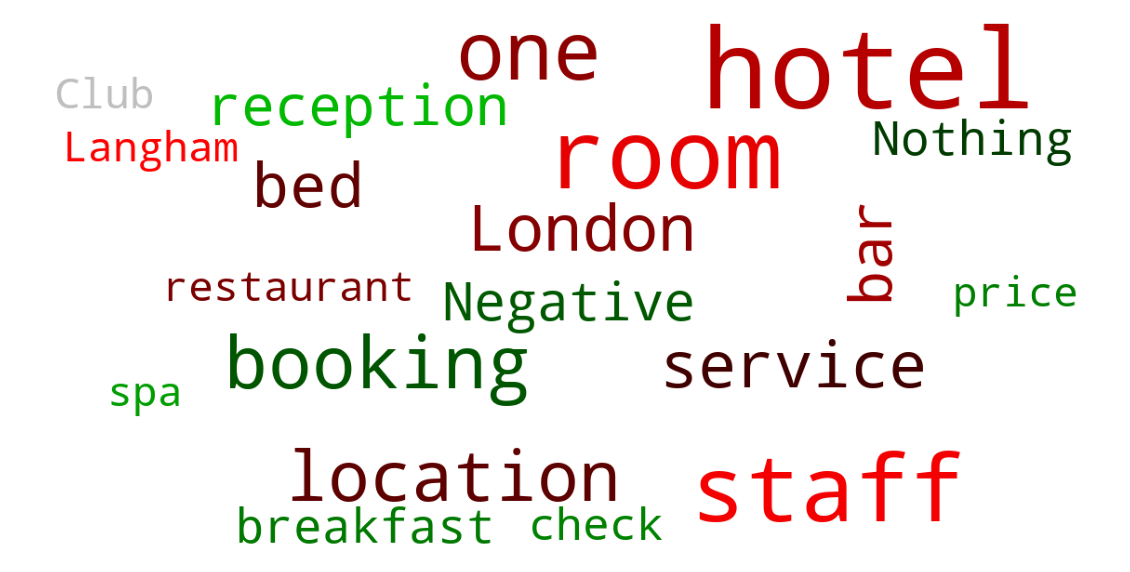

In [12]:
functions.show_wordcloud(df_entity_merged["Entity_name"].values.tolist(), df_entity_merged)

## Sentiment recenzí podle národností

Snažíme se zjistit, jaký sentiment se v průměru objevuje u recenzí daných národností. 

Vybereme 5 národností s nejvyšším průměrným pozitivním sentimentem a 5 národností s nejvyšším průměrným negativním sentimentem.

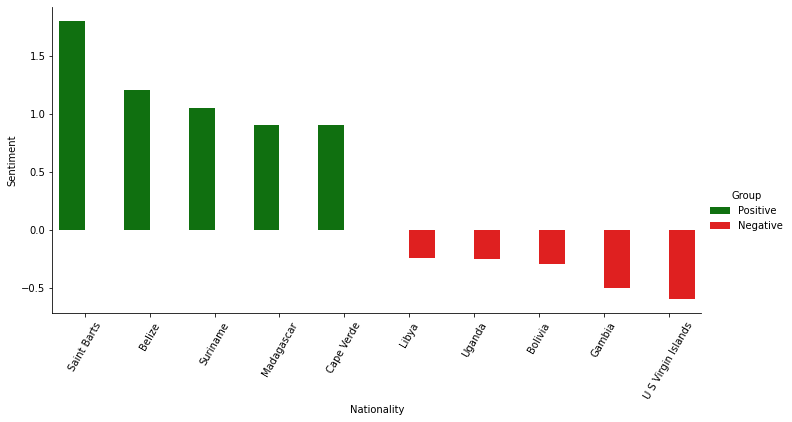

In [6]:
import seaborn
df_nationality = functions.nationality_sentiment(df_for_filter)
plt = seaborn.catplot(x='Reviewer_Nationality', y='sentiment_final', hue='Group', aspect=2, kind='bar', \
                      palette = ["green", "red"], data=df_nationality)
plt.set_xticklabels(rotation=60)
plt.set(xlabel='Nationality', ylabel='Sentiment')

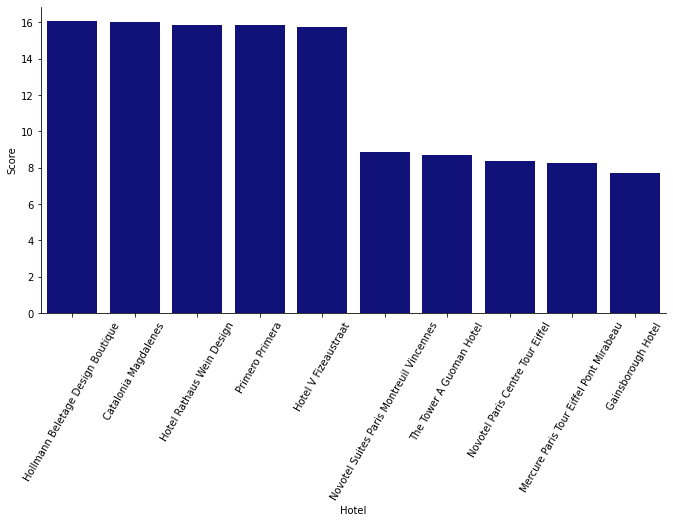

In [7]:
df_hotel_score = functions.hotel_score(df_for_filter)
plt = seaborn.catplot(x='Hotel_Name', y='Score_weighted', aspect=2, kind='bar', \
                      palette = ["darkblue"], data=df_hotel_score)
plt.set_xticklabels(rotation=60)
plt.set(xlabel='Hotel', ylabel='Score')